In [99]:
import pandas as pd
import numpy as np
from math import pow
from scipy import integrate
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


In [2]:
df = pd.read_csv("Data/Grim/data.csv", index_col=0)

In [3]:
def rrc3_pressure_conversion_function_ft(press_kpa):
    pressure = press_kpa * 10
    altitude = (1 - pow(pressure / 1_013.25, 0.190284)) * 145_366.45
    return altitude


def ft_to_meters(ft): return ft * 0.3048

In [4]:
boost_end = 3_500
first_charge = 28_125

In [5]:
altim = df[['pressure (kPa)']].copy()

In [6]:
altim['alt_m_asl'] = altim['pressure (kPa)'].map(rrc3_pressure_conversion_function_ft).map(ft_to_meters)
altim['alt_m_agl'] = altim['alt_m_asl'] - altim['alt_m_asl'].min()

Text(0.5, 1.0, 'Measured Altimeter Altitude')

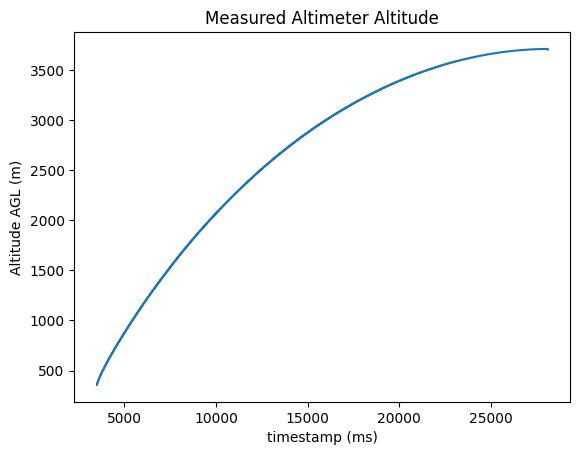

In [7]:
fig = altim.loc[boost_end:first_charge]['alt_m_agl'].plot()
fig.set_ylabel("Altitude AGL (m)")
fig.set_title("Measured Altimeter Altitude")

In [8]:
nice_data = altim.loc[boost_end:first_charge].copy()
nice_data.index = nice_data.index.to_series() / 1000.0
nice_data.index.set_names("timestamp", inplace=True)

In [9]:
nice_data['t'] = nice_data.index

In [10]:
actual_apogee, actual_apogee_index = nice_data['alt_m_agl'].max(), nice_data['alt_m_agl'].argmax() 
actual_apogee_time = nice_data.iloc[actual_apogee_index].t
print(actual_apogee, actual_apogee_time)

3712.8837039159207 28.056


In [77]:
def calc_slope(x):
    fit = np.polyfit(x.index, x, 1)
    slope = fit[0]
    return slope


In [55]:
window_size = 200
center_vel = nice_data['alt_m_agl'].rolling(window_size, min_periods=2, center=True).apply(calc_slope)
notcenter_vel = nice_data['alt_m_agl'].rolling(window_size, min_periods=4, center=False).apply(calc_slope).iloc[60:]

In [167]:
def f(x, a, b, c,):
    return a*x + c + b/x

In [169]:
lookat = nice_data.loc[10:25]
lookatv = notcenter_vel.loc[10:25]

In [170]:
notcenter_vel.to_csv("data.velopcity")

In [171]:
popt, pcov, infodict, m, i = curve_fit(f, lookat.index, lookatv, full_output=True)

In [179]:
pred = f(notcenter_vel.index.to_series(), *popt)
# pred2_args = np.polyfit(lookatv.index, lookatv, 1)
# pred2f = np.poly1d(pred2_args)
# pred2 = pred2f(notcenter_vel.index)
# 
pred_int = integrate.trapezoid(y=pred, x=notcenter_vel.index.to_series())

In [173]:
pred_r2 = r2_score(notcenter_vel, pred)
# pred2_r2 = r2_score(notcenter_vel, pred2)

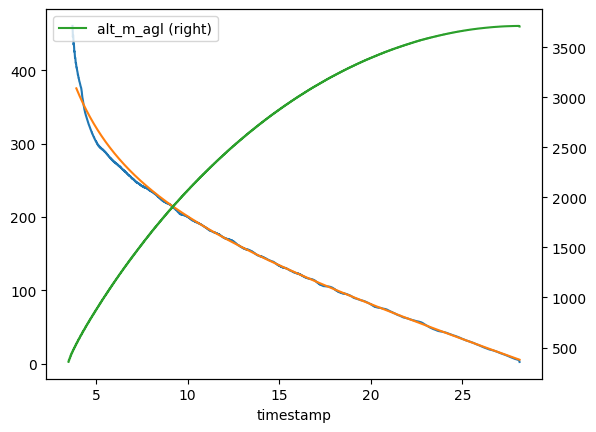

In [178]:
notcenter_vel.plot(label = "Actual Velocity")
p = pred.iloc[60:].plot(label = f"Fancy Prediction 10:25: R2 = {pred_r2:.3f}")
# p.plot(notcenter_vel.index, pred2, label = f"Big dumb line 10:25: R2 = {pred2_r2:.3f}")
p = nice_data['alt_m_agl'].plot(secondary_y=True)
p.plot()
plt.legend()

<Axes: xlabel='timestamp'>

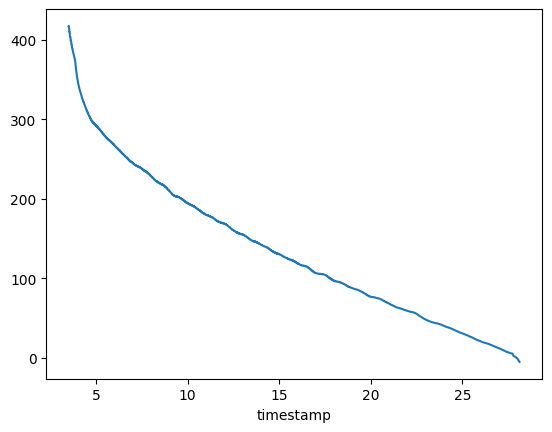

In [181]:
center_vel.plot()

In [217]:
center_acc = notcenter_vel.rolling(30, min_periods=2, center=True).apply(calc_slope)


In [219]:
df2 = df.copy()
df2.set_index(df2.index / 1000, inplace=True)

In [256]:
def  inttohere(row):
    dat = df2.loc[:row]
    return integrate.cumulative_trapezoid(y=dat['accz (m/s^2)'], x = dat.index)

In [258]:
# acc_vel = df2['accz (m/s^2)'].apply(inttohere)

In [279]:
pts = integrate.cumulative_trapezoid(y = df2['accz (m/s^2)'].loc[:], x=df2.index.to_series().loc[:])

In [284]:
pd.Series(pts, index=df2.index.to_series().iloc[1:]).loc[3.713:]

timestamp (ms)
3.713       375.149375
3.716       375.102594
3.719       375.054959
3.723       374.991349
3.727       374.930075
              ...     
400.251    2141.562970
400.255    2141.565896
400.258    2141.568479
400.262    2141.572583
400.265    2141.575509
Length: 112131, dtype: float64

<Axes: xlabel='timestamp (ms)'>

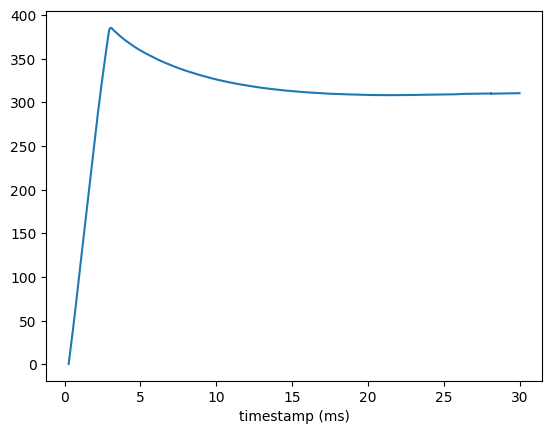

In [280]:
pd.Series(pts, index=df2.index.to_series().loc[:].iloc[1:]).loc[0:30].plot()

<Axes: xlabel='timestamp (ms)'>

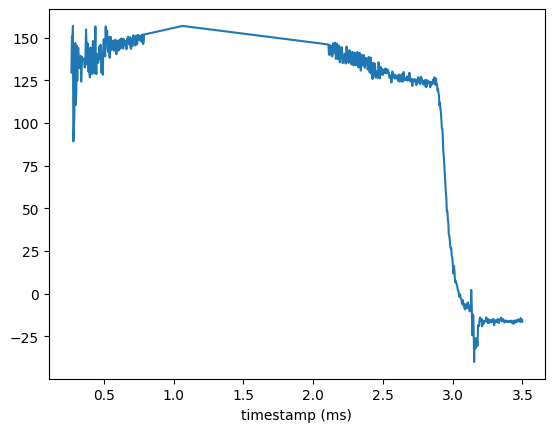

In [255]:
df2['accz (m/s^2)'].loc[0:boost_end/1000].plot()

<Axes: xlabel='timestamp (ms)'>

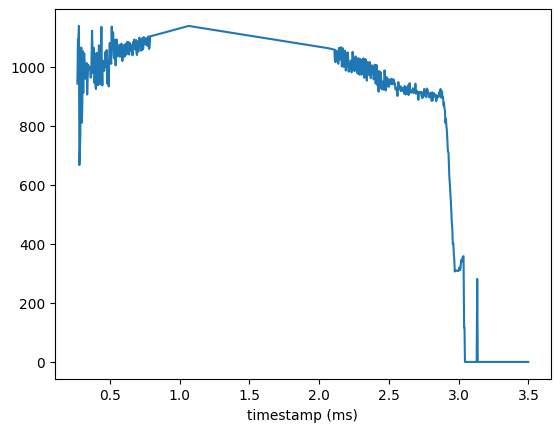

In [252]:
acc_vel.loc[0:boost_end/1000].plot()

<Axes: >

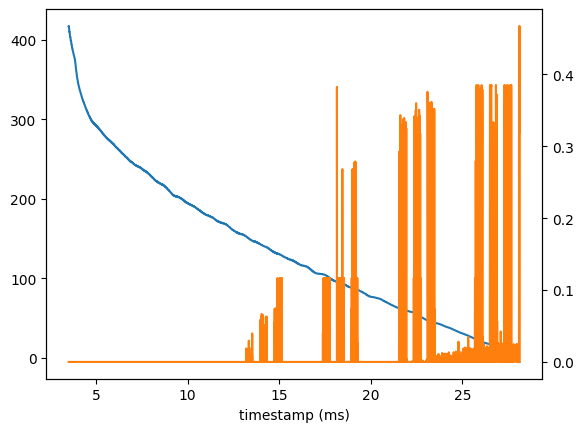

In [247]:
center_vel.plot()
acc_vel.loc[boost_end/1000:first_charge/1000].plot(secondary_y=True)

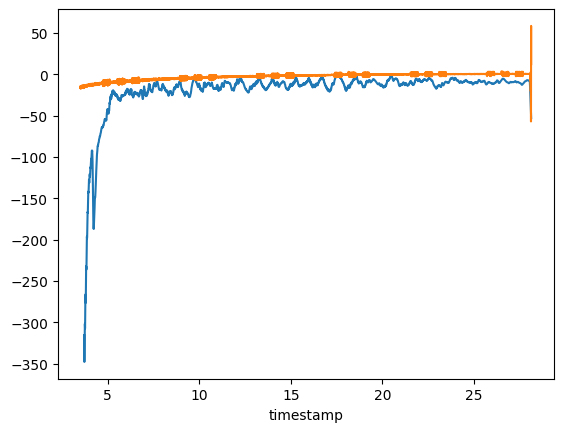

In [218]:
p = (center_acc).plot()
p.plot(df.loc[boost_end:first_charge].index/1000, df['accz (m/s^2)'].loc[boost_end:first_charge])

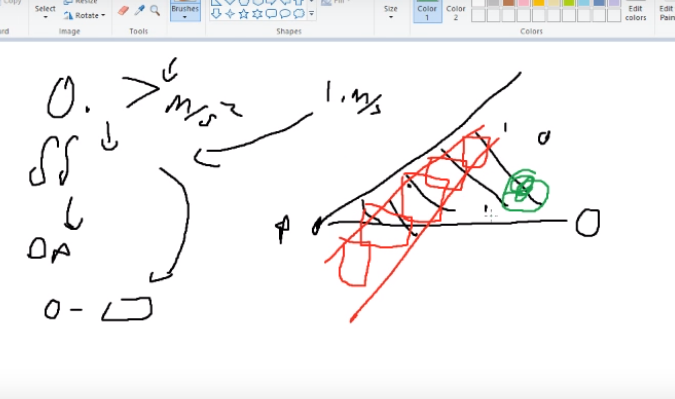

In [214]:
df['accz (m/s^2)'].loc[27.5:].tail(20)

timestamp (ms)
400198    0.861
400202    0.789
400205    1.119
400209    0.866
400213    0.631
400216    0.784
400219    0.732
400223    1.110
400226    0.952
400230    1.052
400233    0.794
400237    0.756
400241    0.937
400244    1.091
400248    0.713
400251    0.698
400255    0.765
400258    0.957
400262    1.095
400265    0.856
Name: accz (m/s^2), dtype: float64